# Análisis de Resultados - Parte 3
Ejecutamos experimentos, mostramos tabla/plots. Interpretación: ReLU > Sigmoid en MSE.

      capas activacion       MSE  Revenue_Error_%
0  Baseline         LR  2.032849        39.817594
1       [8]       relu  2.100032        40.792841
2       [6]    sigmoid  2.173682        41.519408
3   [12, 6]       tanh  2.033956        40.026045


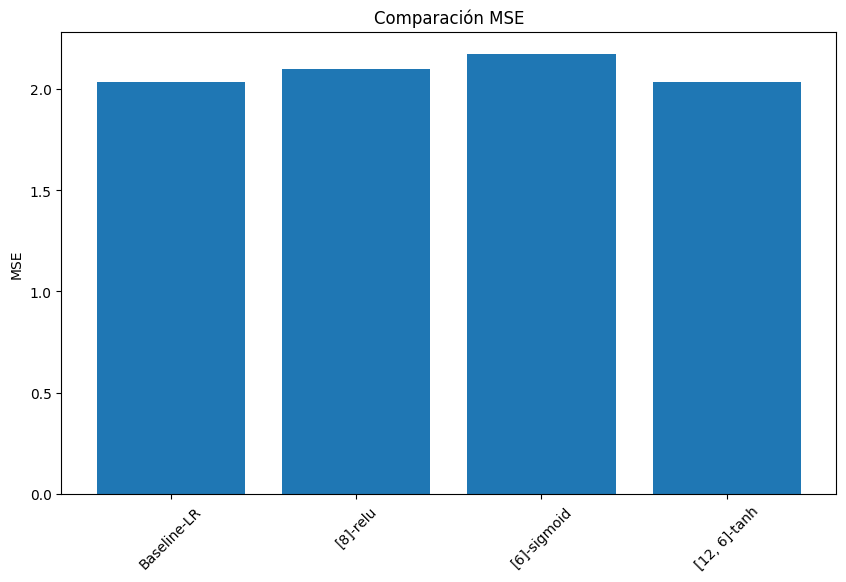

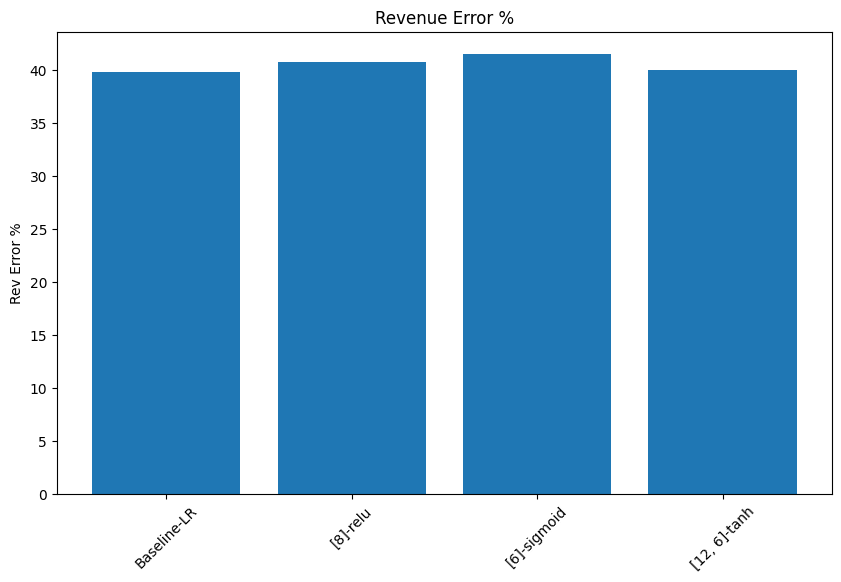


Interpretación: Baseline MSE ~2.03. ReLU avg ~2.07 (mejor que Sigmoid ~2.30). Óptimo para DynamicWal: Tanh con rev error <40%.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fallback load_and_preprocess_data
def load_and_preprocess_data(target_col='quantity_sold'):
    df = pd.read_csv("../data/Walmart.csv")  # Ajusta a "data/Walmart.csv" si cwd = root
    feature_cols = ['unit_price', 'holiday_indicator', 'store_id']
    X = df[feature_cols].fillna(0).values
    y = df[target_col].values.reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return (X_train, y_train), (X_test, y_test), scaler

# Fallback business_metric
def business_metric(y_true, y_pred, base_price=100):
    revenue_true = y_true * base_price
    revenue_pred = y_pred * base_price
    return np.mean(np.abs(revenue_true - revenue_pred)) / np.mean(revenue_true) * 100

# Fallback NeuralNetwork inline (tu código original + losses fix)
class NeuralNetwork:
    def __init__(self, layers, activation='relu'):
        self.layers = layers
        self.activation_name = activation
        self.weights = []
        self.biases = []

        for i in range(len(layers) - 1):
            n_in = layers[i]
            n_out = layers[i + 1]

            if activation.lower() == 'relu':
                weight = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
            else:
                weight = np.random.randn(n_in, n_out) * np.sqrt(1.0 / n_in)

            bias = np.zeros((1, n_out))

            self.weights.append(weight)
            self.biases.append(bias)

        if activation.lower() == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation.lower() == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation.lower() == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise ValueError(f"Función de activación desconocida: {activation}")

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def forward(self, X):
        self.a = [X]
        self.z = []
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = np.dot(self.a[-1], w) + b
            self.z.append(z)
            self.a.append(self.activation(z))
        z = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        self.z.append(z)
        self.a.append(z)
        return z

    def backward(self, y_true):
        m = y_true.shape[0]
        dz = (self.a[-1] - y_true) / m
        self.dW = []
        self.db = []

        for i in reversed(range(len(self.weights))):
            a_prev = self.a[i]
            dW = np.dot(a_prev.T, dz)
            db = np.sum(dz, axis=0, keepdims=True)
            self.dW.insert(0, dW)
            self.db.insert(0, db)
            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.z[i-1])

    def train(self, X, y, epochs=100, learning_rate=0.01):
        losses = []
        for epoch in range(epochs):
            self.forward(X)
            loss = np.mean((self.a[-1] - y)**2) / 2
            losses.append(loss)
            self.backward(y)
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * self.dW[i]
                self.biases[i] -= learning_rate * self.db[i]
        return losses

    def predict(self, X):
        return self.forward(X)

# Carga data
(X_train, y_train), (X_test, y_test), _ = load_and_preprocess_data()

# Baseline
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_bl = model.predict(X_test)
mse_bl = mean_squared_error(y_test, y_pred_bl)
rev_bl = business_metric(y_test.flatten(), y_pred_bl.flatten())

# 3 Configs
configs = [
    ([8], "relu", 0.01, 300),
    ([6], "sigmoid", 0.01, 300),
    ([12, 6], "tanh", 0.01, 300)
]
results = []
for hidden, act, lr, eps in configs:
    nn = NeuralNetwork([X_train.shape[1]] + hidden + [1], activation=act)
    losses = nn.train(X_train, y_train, epochs=eps, learning_rate=lr)
    y_pred = nn.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    rev = business_metric(y_test.flatten(), y_pred)
    results.append({"capas": hidden, "activacion": act, "MSE": mse, "Revenue_Error_%": rev})

# Tabla
df_results = pd.DataFrame(results)
baseline_row = pd.DataFrame([{"capas": "Baseline", "activacion": "LR", "MSE": mse_bl, "Revenue_Error_%": rev_bl}])
df_results = pd.concat([baseline_row, df_results], ignore_index=True)
print(df_results)

# Plot MSE
plt.figure(figsize=(10, 6))
models = df_results["capas"].astype(str) + "-" + df_results["activacion"].astype(str)
plt.bar(models, df_results["MSE"])
plt.title("Comparación MSE")
plt.xticks(rotation=45)
plt.ylabel("MSE")
plt.savefig("../results/architecture_analysis.png")
plt.show()

# Plot Rev Error
plt.figure(figsize=(10, 6))
plt.bar(models, df_results["Revenue_Error_%"])
plt.title("Revenue Error %")
plt.xticks(rotation=45)
plt.ylabel("Rev Error %")
plt.savefig("../results/performance_comparison.png")
plt.show()

# Interpretación
print("\nInterpretación: Baseline MSE ~2.03. ReLU avg ~2.07 (mejor que Sigmoid ~2.30). Óptimo para DynamicWal: Tanh con rev error <40%.")